# Summary Statistics for interpretability techniques

## GITHUB

In [1]:
!git clone https://github.com/adamserag1/Interpretability-for-VRDU-models.git

Cloning into 'Interpretability-for-VRDU-models'...
remote: Enumerating objects: 1611, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 1611 (delta 79), reused 86 (delta 41), pack-reused 1472 (from 1)
Receiving objects: 100% (1611/1611), 26.45 MiB | 26.04 MiB/s, done.
Resolving deltas: 100% (1018/1018), done.


In [ ]:
!git pull https://github.com/adamserag1/Interpretability-for-VRDU-models.git

In [2]:
%cd /content/Interpretability-for-VRDU-models

/content/Interpretability-for-VRDU-models


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install -U datasets

## Libraries

In [6]:
#code
from datasets import load_from_disk
from transformers import LayoutLMv3ForSequenceClassification, AutoProcessor, BrosModel, AutoTokenizer, BrosPreTrainedModel, AutoConfig
import sys
import importlib
def reload_modules():
    for module in list(sys.modules.keys()):
        if module.startswith('vrdu_utils') or module.startswith('Classification_Explain') or module.startswith('lime') or module.startswith('Eval'):
            print(f"Reloading module: {module}")
            importlib.reload(sys.modules[module])

reload_modules()

from vrdu_utils.encoders import *
from Classification_Explain.lime import *
from vrdu_utils.utils import *
import torch
from Eval.eval_suite import *
from Eval.fidelity import *
from Classification_Explain.shap import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
from transformers import logging as hf_logging

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="transformers.modeling_utils",   # the module that emits the msg
)
hf_logging.set_verbosity_error()

## Data + Model Setup

In [9]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/THESIS/explanations.pkl /content/Interpretability-for-VRDU-models/

In [10]:
!cp -r /content/drive/MyDrive/THESIS/rvl_cdip_financial_subset /content
rvl = load_from_disk('/content/rvl_cdip_financial_subset')
dataset_split = rvl.train_test_split(test_size=0.2, seed=42)
val = dataset_split['test']
val_ds = DocSampleDataset(val)

In [11]:
from torch import nn
class BrosForDocumentClassification(BrosPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bros = BrosModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        bbox=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        **kwargs
    ):
        outputs = self.bros(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        # Use the [CLS] token's representation (first token)
        cls_output = outputs.last_hidden_state[:, 0, :]  # shape: (batch_sizef, hidden_size)

        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {
            "loss": loss,
            "logits": logits,
        }

In [12]:
label2id = {"form": 0, "file folder": 1, "budget": 2, "invoice": 3, "questionnaire": 4}
id2label = {0: "form", 1: "file folder", 2: "budget", 3: "invoice", 4: "questionnaire"}

In [13]:

LLMV3 = LayoutLMv3ForSequenceClassification.from_pretrained("adamadam111/layoutlmv3-docclass-finetuned-frz",
                                                            num_labels=5,
                                                            id2label={0: "form", 1: "file folder", 2: "budget", 3: "invoice", 4: "questionnaire"},
                                                            label2id={"form": 0, "file folder": 1, "budget": 2, "invoice": 3, "questionnaire": 4})
LLMV3_proc = AutoProcessor.from_pretrained("adamadam111/layoutlmv3-docclass-finetuned-frz", apply_ocr=False)

LLMV3.to(device)

bros_config = AutoConfig.from_pretrained(
    "adamadam111/bros-docclass-finetuned-frz",
    num_labels=5,
    id2label={0: "form", 1: "file folder", 2: "budget", 3: "invoice", 4: "questionnaire"},
    label2id={"form": 0, "file folder": 1, "budget": 2, "invoice": 3, "questionnaire": 4}
)

BROS = BrosForDocumentClassification.from_pretrained(
    "adamadam111/bros-docclass-finetuned-frz",
    config=bros_config
)
BROS_t = AutoTokenizer.from_pretrained("adamadam111/bros-docclass-finetuned-frz",do_lower_case=True)
LLMV3.to(device)
BROS.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/966 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

BrosForDocumentClassification(
  (bros): BrosModel(
    (embeddings): BrosTextEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (bbox_embeddings): BrosBboxEmbeddings(
      (bbox_sinusoid_emb): BrosPositionalEmbedding2D(
        (x_pos_emb): BrosPositionalEmbedding1D()
        (y_pos_emb): BrosPositionalEmbedding1D()
      )
      (bbox_projection): Linear(in_features=192, out_features=64, bias=False)
    )
    (encoder): BrosEncoder(
      (layer): ModuleList(
        (0-11): 12 x BrosLayer(
          (attention): BrosAttention(
            (self): BrosSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): 

In [14]:
LLMV3_encode = make_layoutlmv3_encoder(LLMV3_proc)
BROS_encode = make_bros_encoder(BROS_t)

@torch.no_grad()
def pred(model, encode_fn, samples):
  enc = encode_fn(samples, device)
  try:
    logits = model(**encode_fn(samples)).logits
  except:
    logits_loss_dict = model(**encode_fn(samples, device))
    logits = logits_loss_dict["logits"]
  return torch.softmax(logits, dim=1).cpu().numpy()



## Finding Samples

In [202]:
pred(LLMV3, LLMV3_encode,[val_ds[5][0]]).argmax()

np.int64(3)

In [15]:
samples = {
    "form": [],
    "file folder": [],
    "budget": [],
    "invoice": [],
    "questionnaire": []
}

classes = {
    'form': [(s,id) for s, id in val_ds if s.label == label2id['form']],
    'invoice': [(s,id) for s, id in val_ds if s.label == label2id['invoice']],
    'budget': [(s,id) for s, id in val_ds if s.label == label2id['budget']],
    'file folder': [(s,id) for s, id in val_ds if s.label == label2id['file folder']],
    'questionnaire': [(s,id) for s, id in val_ds if s.label == label2id['questionnaire']]
}
wrong_ids = {
    "form": [],
    "invoice": [],
    "budget": [],
    "file folder": [],
    "questionnaire": []
}

In [211]:
wrong_ids = {
    "form": [],
    "invoice": [],
    "budget": [],
    "file folder": [],
    "questionnaire": []
}

In [16]:
# 5 Samples from each class
# for example in forms:

def find_incorrect(key):
  for doc, id in classes[key]:
    bros_p = pred(BROS, BROS_encode, [doc])
    llmv3_p = pred(LLMV3, LLMV3_encode, [doc])
    if bros_p.argmax() != label2id[key] or llmv3_p.argmax() != label2id[key]:
      wrong_ids[key].append(id)

find_incorrect('form')
find_incorrect('invoice')
find_incorrect('budget')
find_incorrect('file folder')
find_incorrect('questionnaire')

In [215]:
wrong_ids['invoice']
# print(len(wrong_ids['invoice']))
# print(len(classes['invoice']))

[8,
 50,
 90,
 91,
 104,
 113,
 121,
 123,
 128,
 152,
 154,
 178,
 211,
 231,
 243,
 257,
 309,
 315,
 330,
 336,
 337,
 377,
 407,
 451,
 468,
 474,
 479,
 481,
 496,
 542,
 555,
 620,
 624,
 754,
 757,
 761,
 767,
 786,
 804,
 821,
 843,
 850,
 887,
 938,
 993,
 995]

In [41]:
forms = [classes['form'][5], classes['form'][10], classes['form'][56], classes['form'][150], classes['form'][77]]
invoices = [classes['invoice'][3], classes['invoice'][12], classes['invoice'][29], classes['invoice'][40], classes['invoice'][22]]
budgets = [classes['budget'][1], classes['budget'][3], classes['budget'][13], classes['budget'][33], classes['budget'][21]]
file_folders = [classes['file folder'][32], classes['file folder'][2], classes['file folder'][11], classes['file folder'][94], classes['file folder'][29]]
questionnaires = [classes['questionnaire'][5], classes['questionnaire'][1], classes['questionnaire'][35], classes['questionnaire'][36], classes['questionnaire'][70]]

def check_incorrect(key, docs):
  for idx, (doc, id) in enumerate(docs):
    if id in wrong_ids[key]:
      print(idx)
      return False
  return True

assert check_incorrect('form', forms)
assert check_incorrect('invoice', invoices)
assert check_incorrect('budget', budgets)
assert check_incorrect('file folder', file_folders)
assert check_incorrect('questionnaire', questionnaires)

In [42]:
final_samples = {
    "form": forms,
    "file folder": file_folders,
    "budget": budgets,
    "invoice": invoices,
    "questionnaire": questionnaires
}

In [29]:
for idx, sample in enumerate(final_samples['file folder']):
  if len(sample[0].words) == 0:
    print(idx)

## Obtain Explanations

In [58]:
from tqdm import tqdm
def obtain_explainers(key, label):
  text_explainers = {
      'BROS lime' : LimeTextExplainer(BROS, BROS_encode, mask_token=BROS_t.mask_token, kernel_width_factor = 0.75, labels=[label]),
      'LLMV3 lime' : LimeTextExplainer(LLMV3, LLMV3_encode, mask_token = LLMV3_proc.tokenizer.mask_token, kernel_width_factor = 0.75, labels = [label]),
      'BROS shap' : SHAPTextExplainer(BROS, BROS_encode, BROS_t, mask_token=BROS_t.mask_token, device=device),
      'LLMV3 shap' : SHAPTextExplainer(LLMV3, LLMV3_encode, LLMV3_proc.tokenizer,mask_token=LLMV3_proc.tokenizer.mask_token, device=device)
  }

  layout_explainers = {
      'BROS lime' : LimeLayoutExplainer(BROS, BROS_encode, mask_token=BROS_t.mask_token, kernel_width_factor = 0.75, labels=[label]),
      'LLMV3 lime' : LimeLayoutExplainer(LLMV3, LLMV3_encode, mask_token = LLMV3_proc.tokenizer.mask_token, kernel_width_factor = 0.75, labels = [label]),
      'BROS shap' : SHAPLayoutExplainer(BROS, BROS_encode, device=device),
      'LLMV3 shap' : SHAPLayoutExplainer(LLMV3, LLMV3_encode, device=device)
  }

  vision_explainers = {
      'LLMV3 lime' : LimeVisionExplainer(LLMV3, LLMV3_encode, label = [label], device=device),
      'LLMV3 shap' : SHAPVisionExplainer(LLMV3, LLMV3_encode, device=device, class_idx=4, mask_value='blur(64,64)')
  }

  return text_explainers, layout_explainers, vision_explainers

def obtain_explanations(text, layout, vision, key):
  explanations = {}
  print(text)
  for idx, sample in tqdm(enumerate(final_samples[key]), desc=f"Obtaining explanations for {key}s"):
    explanations.update({f'{idx} - [T] - {key}' : explainer.explain(sample[0], nsamples=2000) for key, explainer in text.items() if 'shap' in key})
    explanations.update({f'{idx} - [L] - {key}' : explainer.explain(sample[0], nsamples=2000) for key, explainer in layout.items() if 'shap' in key})
    explanations.update({f'{idx} - [V] - {key}' : explainer.explain(sample[0], nsamples=1000) for key, explainer in vision.items() if 'shap' in key})
    explanations.update({f'{idx} - [T] - {key}' : explainer.explain(sample[0], num_samples=2000) for key, explainer in text.items() if 'lime' in key})
    explanations.update({f'{idx} - [L] - {key}' : explainer.explain(sample[0], num_samples=2000) for key, explainer in layout.items() if 'lime' in key})
    explanations.update({f'{idx} - [V] - {key}' : explainer.explain(sample[0], num_samples=1000) for key, explainer in vision.items() if 'lime' in key})

  return explanations



In [81]:
print(class_explanations['form_explanations']['0 - [T] - BROS shap'])

.values =
array([[[ 1.28881972e-02,  1.45920267e-02, -1.21472279e-02,
          4.21082973e-03, -6.26965761e-02],
        [ 6.41240738e-04, -1.01944606e-02, -1.24267737e-02,
         -4.27381992e-02, -9.00069873e-03],
        [-2.73817763e-02, -3.47570578e-02, -1.22576555e-02,
         -1.13966068e-01,  1.14896158e-01],
        ...,
        [ 2.99168549e-03, -4.98048067e-02, -1.11522675e-02,
         -2.34126250e-02, -4.03345426e-02],
        [ 3.42232330e-05, -1.39725208e-02, -4.54346339e-04,
          5.28788567e-03, -9.07818476e-03],
        [ 1.47612176e-03,  5.42112192e-03,  1.17010276e-02,
          3.13583215e-02, -1.07898315e-03]]])

.base_values =
array([[-3.41791987, -0.5262745 , -3.07720041, -2.80110025, -1.31086671]])

.data =
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 

In [40]:
# with (open("explanations.pkl", "rb")) as openfile:
#     while True:
#         try:
#             class_explanations.update(pickle.load(openfile))
#         except EOFError:
#             break
len(class_explanations)

2

In [59]:
import pickle
explainers = {key: obtain_explainers(key, label2id[key]) for key, _ in final_samples.items()}

class_explanations = {}
class_explanations.update({'form_explanations' : obtain_explanations(explainers['form'][0], explainers['form'][1], explainers['form'][2], 'form')})
class_explanations.update({'file_folder_explanations' : obtain_explanations(explainers['file folder'][0], explainers['file folder'][1], explainers['file folder'][2], 'file folder')})
class_explanations.update({'budget_explanations' : obtain_explanations(explainers['budget'][0], explainers['budget'][1], explainers['budget'][2], 'budget')})
class_explanations.update({'invoice_explanations' : obtain_explanations(explainers['invoice'][0], explainers['invoice'][1], explainers['invoice'][2], 'invoice')})
class_explanations.update({'questionnaire_explanations' : obtain_explanations(explainers['questionnaire'][0], explainers['questionnaire'][1], explainers['questionnaire'][2], 'questionnaire')})

# OPEN PICLE FILE
# STORE IN CLASS_EXPLANATIONS
# UPDATE WITH INVOICE EXPLANATIONS
# DO REST OF POSTER


with open('explanations_final_final.pkl', 'wb') as fp:
    pickle.dump(class_explanations, fp)
    print('Dictionary saved successfully to file')

!cp explanations_final_final.pkl /content/drive/MyDrive/THESIS/

{'BROS lime': <Classification_Explain.lime.LimeTextExplainer object at 0x7bffac8cecd0>, 'LLMV3 lime': <Classification_Explain.lime.LimeTextExplainer object at 0x7bffac992110>, 'BROS shap': <Classification_Explain.shap.SHAPTextExplainer object at 0x7bff5ff02010>, 'LLMV3 shap': <Classification_Explain.shap.SHAPTextExplainer object at 0x7bffac2b3150>}


Obtaining explanations for forms: 0it [00:00, ?it/s]
PermutationExplainer explainer: 2it [00:49, 49.99s/it]               

PermutationExplainer explainer: 2it [00:45, 45.41s/it]               

PermutationExplainer explainer: 2it [00:49, 49.93s/it]               

PermutationExplainer explainer: 2it [00:44, 44.57s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:35, 35.05s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:49<00:00,  2.52it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:49<00:00,  2.53it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for forms: 1it [08:58, 538.22s/it]
PermutationExplainer explainer: 2it [00:49, 49.79s/it]               

PermutationExplainer explainer: 2it [00:45, 45.87s/it]               

PermutationExplainer explainer: 2it [00:50, 50.00s/it]               

PermutationExplainer explainer: 2it [00:44, 44.75s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:35, 35.39s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:51<00:00,  2.44it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:49<00:00,  2.50it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for forms: 2it [17:56, 538.13s/it]
PermutationExplainer explainer: 2it [00:54, 54.06s/it]               

PermutationExplainer explainer: 2it [00:59, 59.14s/it]               

PermutationExplainer explainer: 2it [00:54, 54.13s/it]               

PermutationExplainer explainer: 2it [00:58, 58.32s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:39, 39.82s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for forms: 3it [27:54, 565.64s/it]
PermutationExplainer explainer: 2it [00:54, 54.63s/it]               

PermutationExplainer explainer: 2it [00:55, 55.78s/it]               

PermutationExplainer explainer: 2it [00:54, 54.39s/it]               

PermutationExplainer explainer: 2it [00:54, 54.22s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:38, 38.48s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for forms: 4it [37:38, 572.82s/it]
PermutationExplainer explainer: 2it [00:51, 51.83s/it]               

PermutationExplainer explainer: 2it [00:56, 56.11s/it]               

PermutationExplainer explainer: 2it [00:51, 51.69s/it]               

PermutationExplainer explainer: 2it [00:54, 54.77s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:40, 40.68s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for forms: 5it [47:30, 570.08s/it]


{'BROS lime': <Classification_Explain.lime.LimeTextExplainer object at 0x7bff5c92a2d0>, 'LLMV3 lime': <Classification_Explain.lime.LimeTextExplainer object at 0x7bff5c92a290>, 'BROS shap': <Classification_Explain.shap.SHAPTextExplainer object at 0x7bff5c3e9cd0>, 'LLMV3 shap': <Classification_Explain.shap.SHAPTextExplainer object at 0x7bffac6f9650>}


Obtaining explanations for file folders: 0it [00:00, ?it/s]
PermutationExplainer explainer: 2it [00:58, 58.36s/it]               

PermutationExplainer explainer: 2it [01:06, 66.52s/it]               

PermutationExplainer explainer: 2it [00:58, 58.35s/it]               

PermutationExplainer explainer: 2it [01:06, 66.38s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:42, 42.29s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.27it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for file folders: 1it [10:41, 641.27s/it]
PermutationExplainer explainer: 2it [00:56, 56.12s/it]               

PermutationExplainer explainer: 2it [01:05, 65.44s/it]               

PermutationExplainer explainer: 2it [00:56, 56.13s/it]               

PermutationExplainer explainer: 2it [01:05, 65.51s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:40, 40.26s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for file folders: 2it [21:05, 631.38s/it]
PermutationExplainer explainer: 2it [00:53, 53.98s/it]               

PermutationExplainer explainer: 2it [01:01, 61.91s/it]               

PermutationExplainer explainer: 2it [00:53, 53.64s/it]               

PermutationExplainer explainer: 2it [01:01, 61.48s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:39, 39.94s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for file folders: 3it [31:25, 626.01s/it]
PermutationExplainer explainer: 2it [00:54, 54.37s/it]               

PermutationExplainer explainer: 2it [01:02, 62.35s/it]               

PermutationExplainer explainer: 2it [00:54, 54.17s/it]               

PermutationExplainer explainer: 2it [01:02, 62.29s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:40, 40.04s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for file folders: 4it [41:45, 623.80s/it]
PermutationExplainer explainer: 2it [00:53, 53.14s/it]               

PermutationExplainer explainer: 2it [01:03, 63.82s/it]               

PermutationExplainer explainer: 2it [00:52, 52.48s/it]               

PermutationExplainer explainer: 2it [01:03, 63.68s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:41, 41.04s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for file folders: 5it [52:08, 625.67s/it]


{'BROS lime': <Classification_Explain.lime.LimeTextExplainer object at 0x7bffac0b1b90>, 'LLMV3 lime': <Classification_Explain.lime.LimeTextExplainer object at 0x7bffac0b3b50>, 'BROS shap': <Classification_Explain.shap.SHAPTextExplainer object at 0x7bffac0b0a10>, 'LLMV3 shap': <Classification_Explain.shap.SHAPTextExplainer object at 0x7bffac0b0f50>}


Obtaining explanations for budgets: 0it [00:00, ?it/s]
PermutationExplainer explainer: 2it [00:50, 50.11s/it]               

PermutationExplainer explainer: 2it [00:53, 53.56s/it]               

PermutationExplainer explainer: 2it [00:49, 49.82s/it]               

PermutationExplainer explainer: 2it [00:51, 51.46s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:38, 38.76s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for budgets: 1it [09:43, 583.63s/it]
PermutationExplainer explainer: 2it [00:52, 52.92s/it]               

PermutationExplainer explainer: 2it [00:56, 56.85s/it]               

PermutationExplainer explainer: 2it [00:52, 52.94s/it]               

PermutationExplainer explainer: 2it [00:55, 55.76s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:38, 38.83s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:58<00:00,  2.12it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:57<00:00,  2.16it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for budgets: 2it [19:39, 590.60s/it]
PermutationExplainer explainer: 2it [00:54, 54.79s/it]               

PermutationExplainer explainer: 2it [01:02, 62.66s/it]               

PermutationExplainer explainer: 2it [00:54, 54.74s/it]               

PermutationExplainer explainer: 2it [01:02, 62.48s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:41, 41.21s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for budgets: 3it [29:57, 603.42s/it]
PermutationExplainer explainer: 2it [00:52, 52.71s/it]               

PermutationExplainer explainer: 2it [00:57, 57.70s/it]               

PermutationExplainer explainer: 2it [00:52, 52.81s/it]               

PermutationExplainer explainer: 2it [00:56, 56.08s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:39, 39.15s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:57<00:00,  2.16it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for budgets: 4it [39:57, 601.90s/it]
PermutationExplainer explainer: 2it [00:53, 53.06s/it]               

PermutationExplainer explainer: 2it [00:55, 55.26s/it]               

PermutationExplainer explainer: 2it [00:52, 52.96s/it]               

PermutationExplainer explainer: 2it [00:51, 51.88s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:37, 37.04s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for budgets: 5it [49:37, 595.47s/it]


{'BROS lime': <Classification_Explain.lime.LimeTextExplainer object at 0x7bffac0b2ad0>, 'LLMV3 lime': <Classification_Explain.lime.LimeTextExplainer object at 0x7bffac0b1c10>, 'BROS shap': <Classification_Explain.shap.SHAPTextExplainer object at 0x7bffac0b36d0>, 'LLMV3 shap': <Classification_Explain.shap.SHAPTextExplainer object at 0x7bffac0b2a10>}


Obtaining explanations for invoices: 0it [00:00, ?it/s]
PermutationExplainer explainer: 2it [00:48, 48.54s/it]               

PermutationExplainer explainer: 2it [00:51, 52.00s/it]               

PermutationExplainer explainer: 2it [00:48, 48.52s/it]               

PermutationExplainer explainer: 2it [00:50, 50.34s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:38, 38.59s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for invoices: 1it [09:23, 563.78s/it]
PermutationExplainer explainer: 2it [00:49, 49.29s/it]               

PermutationExplainer explainer: 2it [00:50, 50.90s/it]               

PermutationExplainer explainer: 2it [00:49, 49.48s/it]               

PermutationExplainer explainer: 2it [00:48, 48.48s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:37, 37.19s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for invoices: 2it [18:40, 559.52s/it]
PermutationExplainer explainer: 2it [00:53, 53.50s/it]               

PermutationExplainer explainer: 2it [00:57, 57.56s/it]               

PermutationExplainer explainer: 2it [00:54, 54.03s/it]               

PermutationExplainer explainer: 2it [00:55, 55.93s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:38, 38.41s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for invoices: 3it [28:33, 574.84s/it]
PermutationExplainer explainer: 2it [00:50, 50.15s/it]               

PermutationExplainer explainer: 2it [00:54, 54.16s/it]               

PermutationExplainer explainer: 2it [00:50, 50.26s/it]               

PermutationExplainer explainer: 2it [00:53, 53.04s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:39, 39.05s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for invoices: 4it [38:16, 578.20s/it]
PermutationExplainer explainer: 2it [00:48, 48.43s/it]               

PermutationExplainer explainer: 2it [00:50, 50.50s/it]               

PermutationExplainer explainer: 2it [00:48, 48.40s/it]               

PermutationExplainer explainer: 2it [00:48, 48.59s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:37, 37.46s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for invoices: 5it [47:33, 570.66s/it]


{'BROS lime': <Classification_Explain.lime.LimeTextExplainer object at 0x7bffac0b1510>, 'LLMV3 lime': <Classification_Explain.lime.LimeTextExplainer object at 0x7bffc5b575d0>, 'BROS shap': <Classification_Explain.shap.SHAPTextExplainer object at 0x7bffc5b56cd0>, 'LLMV3 shap': <Classification_Explain.shap.SHAPTextExplainer object at 0x7bffac18ba90>}


Obtaining explanations for questionnaires: 0it [00:00, ?it/s]
PermutationExplainer explainer: 2it [00:55, 55.14s/it]               

PermutationExplainer explainer: 2it [00:52, 52.10s/it]               

PermutationExplainer explainer: 2it [00:55, 55.26s/it]               

PermutationExplainer explainer: 2it [00:50, 50.13s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:36, 36.19s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:52<00:00,  2.37it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:50<00:00,  2.46it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for questionnaires: 1it [09:29, 569.33s/it]
PermutationExplainer explainer: 2it [00:41, 41.73s/it]               

PermutationExplainer explainer: 2it [00:39, 39.58s/it]               

PermutationExplainer explainer: 2it [00:41, 41.50s/it]               

PermutationExplainer explainer: 2it [00:37, 37.36s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:35, 35.03s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:52<00:00,  2.37it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:50<00:00,  2.49it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for questionnaires: 2it [18:04, 537.19s/it]
PermutationExplainer explainer: 2it [00:40, 40.25s/it]               

PermutationExplainer explainer: 2it [00:37, 37.99s/it]               

PermutationExplainer explainer: 2it [00:40, 40.73s/it]               

PermutationExplainer explainer: 2it [00:37, 37.43s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:36, 36.77s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:51<00:00,  2.42it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:51<00:00,  2.43it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for questionnaires: 3it [26:42, 528.67s/it]
PermutationExplainer explainer: 2it [00:52, 52.32s/it]               

PermutationExplainer explainer: 2it [00:54, 54.36s/it]               

PermutationExplainer explainer: 2it [00:52, 52.93s/it]               

PermutationExplainer explainer: 2it [00:53, 53.77s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:39, 39.11s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for questionnaires: 4it [36:29, 551.55s/it]
PermutationExplainer explainer: 2it [00:53, 53.42s/it]               

PermutationExplainer explainer: 2it [00:53, 53.27s/it]               

PermutationExplainer explainer: 2it [00:53, 53.26s/it]               

PermutationExplainer explainer: 2it [00:50, 50.92s/it]               


  0%|          | 0/998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:36, 36.86s/it]               


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT



[LIME] - Text: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE



[LIME] - Text: 100%|██████████| 125/125 [00:52<00:00,  2.39it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Obtaining explanations for questionnaires: 5it [46:06, 553.22s/it]


Dictionary saved successfully to file


In [44]:
!cp explanations_final.pkl /content/drive/MyDrive/THESIS/

## Investigation

In [60]:
raw_explanations = {}
with (open("explanations_final_final.pkl", "rb")) as openfile:
    while True:
        try:
            raw_explanations.update(pickle.load(openfile))
        except EOFError:
            break


In [61]:
len(raw_explanations)

5

In [64]:
len(raw_explanations['file_folder_explanations'])

50

In [95]:
import numpy as np
from collections import defaultdict

TAG2MOD = {'[T]': 'text', '[L]': 'layout', '[V]': 'vision'}

def _sum_abs(expl, modality, cls_idx):
    """
    Σ|ϕ_j|  with class-aware slicing for TEXT and LAYOUT.
    """
    # --- pull raw Shapley tensor ------------------------------------------------
    if hasattr(expl, 'values'):
        vals = np.asarray(expl.values)
    elif isinstance(expl, dict) and 'values' in expl:   # old pickles
        vals = np.asarray(expl['values'])
    else:                                               # fallback
        vals = np.asarray(expl)

    # --- select the class dimension when needed --------------------------------
    if modality in ('text', 'layout'):
        # robust slicing: works for (tok, cls), (1, tok, cls), or any ...cls
        if vals.ndim >= 2:
            vals = np.take(vals, cls_idx, axis=-1)

    # now vals is 1- or 2-D  (tokens [, 1])
    return np.abs(vals).sum()

def compute_mm_shap_nested(class_explanations, label2id):
    """
    Returns
        mm_by_sample[(model, cls, idx)] = {'text':…, 'layout':…, 'vision':…}
        mm_mean[model][cls]             = {'text':…, 'layout':…, 'vision':…}
    Follows MM-SHAP Eq. (2–3); only *shap* explanations are used.
    """
    bucket = defaultdict(lambda: defaultdict(dict))  # key → modality → expl

    # 1. regroup by (model-method, class, sample-idx)
    for cls_wrap, expls in class_explanations.items():
        cls = cls_wrap.replace('_explanations', '')
        # handle file folder
        if cls == 'file_folder':
          cls = 'file folder'
        cls_idx = label2id[cls]                      # e.g. 'invoice' → 3 :contentReference[oaicite:4]{index=4}
        for k, expl in expls.items():
            parts = [p.strip() for p in k.split('-')]
            idx       = int(parts[0])
            tag       = parts[1]                     # '[T]' / '[L]' / '[V]'
            modelmet  = '-'.join(parts[2:])          # 'BROS shap', …
            if 'shap' not in modelmet.lower():
                continue
            modality  = TAG2MOD[tag]
            bucket[(modelmet, cls, idx, cls_idx)][modality] = expl

    # 2. compute shares per sample
    mm_by_sample, per_cls_tmp = {}, defaultdict(list)
    for (modelmet, cls, idx, cls_idx), mods in bucket.items():
        phi = {m: _sum_abs(e, m, cls_idx) for m, e in mods.items()}
        total = sum(phi.values()) or 1.0
        share = {m: phi.get(m, 0.0) / total for m in ['text', 'layout', 'vision']}
        mm_by_sample[(modelmet, cls, idx)] = share
        per_cls_tmp[(modelmet, cls)].append(list(share.values()))

    # 3. arithmetic mean per class (additivity property of Shapley values justifies this) :contentReference[oaicite:5]{index=5}
    mm_mean = defaultdict(dict)
    for (modelmet, cls), rows in per_cls_tmp.items():
        arr = np.asarray(rows)
        mm_mean[modelmet][cls] = dict(zip(['text', 'layout', 'vision'], arr.mean(0)))

    return mm_by_sample, mm_mean

In [105]:
mm_sample, mm_class = compute_mm_shap_nested(raw_explanations, label2id)

# Example: average modality shares for *invoices* under the LLMV3 SHAP explanations
LLMV3_mm_shap = {
  'form' : mm_class['LLMV3 shap']['form'],
  'invoice' : mm_class['LLMV3 shap']['invoice'],
  'file folder' : mm_class['LLMV3 shap']['file folder'],
  'budget' : mm_class['LLMV3 shap']['budget'],
  'questionnaire' : mm_class['LLMV3 shap']['questionnaire']
}

BROS_mm_shap = {
  'form' : mm_class['BROS shap']['form'],
  'invoice' : mm_class['BROS shap']['invoice'],
  'file folder' : mm_class['BROS shap']['file folder'],
  'budget' : mm_class['BROS shap']['budget'],
  'questionnaire' : mm_class['BROS shap']['questionnaire']
}
print(LLMV3_mm_shap)
print(BROS_mm_shap)
import pandas as pd

dfllmv3 = pd.DataFrame(LLMV3_mm_shap)
dfbros = pd.DataFrame(BROS_mm_shap)


{'form': {'text': np.float64(0.6906447062823811), 'layout': np.float64(0.1381081141897254), 'vision': np.float64(0.17124717952789342)}, 'invoice': {'text': np.float64(0.932509315170295), 'layout': np.float64(0.027882948411285115), 'vision': np.float64(0.039607736418419914)}, 'file folder': {'text': np.float64(0.03601894942614008), 'layout': np.float64(0.013321227724881275), 'vision': np.float64(0.9506598228489788)}, 'budget': {'text': np.float64(0.5176062632981699), 'layout': np.float64(0.07961935345620094), 'vision': np.float64(0.402774383245629)}, 'questionnaire': {'text': np.float64(0.9923044905562157), 'layout': np.float64(0.006356657010280484), 'vision': np.float64(0.0013388524335037825)}}
{'form': {'text': np.float64(0.9953242439367888), 'layout': np.float64(0.004675756063211351), 'vision': np.float64(0.0)}, 'invoice': {'text': np.float64(0.9629942016903696), 'layout': np.float64(0.03700579830963047), 'vision': np.float64(0.0)}, 'file folder': {'text': np.float64(0.67557623056851

In [107]:
dfbros

,form,invoice,file folder,budget,questionnaire
text,0.995324,0.962994,0.675576,0.990845,0.999776
layout,0.004676,0.037006,0.324424,0.009155,0.000224
vision,0.000000,0.000000,0.000000,0.000000,0.000000


In [132]:
MODEL_HANDLES = {                       # str in expl_type → (model , encode_fn)
    "BROS":   (BROS,   BROS_encode),
    "LLMV3":  (LLMV3,  LLMV3_encode),
}

MASK_TOKEN = {                          # model id → text mask token
    "BROS":  BROS_t.mask_token,
    "LLMV3": LLMV3_proc.tokenizer.mask_token,
}

SLIC_KW = dict(n_segments=200, compactness=20.0, sigma=1.0, start_label=1)

# --------------------------------------------------------------------------
# HELPER 1 – extract ordered (positive) feature indices
# --------------------------------------------------------------------------
def _rank_positive_feats(expl, expl_type, modality, cls_idx):
    """
    Return list[int] – feature indices sorted by descending *positive* weight.
    Works for both SHAP & LIME.
    """
    if "shap" in expl_type.lower():
        vals = expl.values
        if modality in ("text", "layout"):           # slice class dim
            while vals.ndim > 2: vals = vals[0]      # squeeze dummy batch
            if vals.ndim == 2: vals = vals[:, cls_idx]
        vals = vals.flatten()
        idx = np.argsort(-vals)                      # descending
        return [i for i in idx if vals[i] > 0]

    # ------------------- LIME -------------------
    m = expl.as_map()[cls_idx]
    pos = [(i, w) for i, w in m if w > 0]
    return [i for i, _ in sorted(pos, key=lambda x: -x[1])]

# --------------------------------------------------------------------------
# HELPER 2 – perturb a DocSample according to modality & feature set
# --------------------------------------------------------------------------
def _perturb(sample, modality, feat_ids, model_tag, segments=None):
    if modality == "text":                           #   ---- TEXT ----
        words = [w if i not in feat_ids else MASK_TOKEN[model_tag]
                 for i, w in enumerate(sample.words)]
        return DocSample(sample.image, words, sample.bboxes,
                         ner_tags=sample.ner_tags, label=sample.label)

    if modality == "layout":                         #   ---- LAYOUT ---
        w, h = sample.image.size
        boxes = [b if i not in feat_ids else [0, 0, w, h]
                 for i, b in enumerate(sample.bboxes)]
        return DocSample(sample.image, sample.words, boxes,
                         ner_tags=sample.ner_tags, label=sample.label)

    if modality == "vision":                         #   ---- VISION ---
        if segments is None:
            img_np  = np.asarray(sample.image)
            segments = slic(img_np, **SLIC_KW)
        from PIL import ImageFilter
        blur = sample.image.filter(ImageFilter.GaussianBlur(64))
        base, blur_np = np.array(sample.image), np.array(blur)
        mask = np.isin(segments, feat_ids)
        out = base.copy()
        out[mask] = blur_np[mask]
        return DocSample(Image.fromarray(out.astype(np.uint8)),
                         sample.words, sample.bboxes,
                         ner_tags=sample.ner_tags, label=sample.label)

    raise ValueError(f"Unknown modality: {modality}")

# --------------------------------------------------------------------------
# HELPER 3 – model inference → P(target class)
# --------------------------------------------------------------------------
@torch.no_grad()
def _predict_prob(samples, model, encode_fn, cls_idx, device):
    enc = encode_fn(samples, device)
    logits = model(**enc).logits
    probs  = torch.softmax(logits, dim=-1)
    return probs[:, cls_idx].cpu().numpy()           # (N,)

# --------------------------------------------------------------------------
# MAIN DRIVER – draw AOPC curves
# --------------------------------------------------------------------------
def plot_aopc_curves(target_cls: str,
                     expl_type: str,
                     modality: str,
                     K: int = 20,
                     device: torch.device | str = "cuda"):
    """
    Draw AOPC curves (prob. vs k) for every sample in `target_cls`
    using explanations `expl_type` and `modality`.
    """
    tag = "[T]" if modality=="text" else "[L]" if modality=="layout" else "[V]"

    cls_wrap = f"{target_cls}_explanations"
    if cls_wrap == 'file folder_explanations':
      cls_wrap = 'file_folder_explanations'
    expls = raw_explanations[cls_wrap]

    model_tag = expl_type.split()[0]                 # "BROS" / "LLMV3"
    model, encode_fn = MODEL_HANDLES[model_tag]
    cls_idx = label2id[target_cls]

    x = np.arange(0, K+1)
    aopc_acc = []

    plt.figure(figsize=(6,4))

    for k_str, expl in expls.items():
        if tag not in k_str or expl_type not in k_str:
            continue
        s_idx   = int(k_str.split("-")[0].strip())
        sample  = final_samples[target_cls][s_idx]

        ranked = _rank_positive_feats(expl, expl_type, modality, cls_idx)
        if not ranked:
            continue

        seg = None
        if modality == "vision":
            img_np = np.asarray(sample[0].image)
            ch_ax  = -1 if img_np.ndim == 3 else None
            seg    = slic(img_np, channel_axis=ch_ax, **SLIC_KW)

        probs = []
        print([sample[0]])
        p0 = _predict_prob([sample[0]], model, encode_fn, cls_idx, device)[0]
        probs.append(p0)

        masked = []
        for k in range(1, K+1):
            masked.append(ranked[k-1] if k-1 < len(ranked) else None)
            pert = _perturb(sample[0], modality, masked, model_tag, seg)
            pk   = _predict_prob([pert], model, encode_fn, cls_idx, device)[0]
            probs.append(pk)

        plt.plot(x, probs, lw=1)
        aopc_acc.append(np.trapz(p0 - np.array(probs[1:]), dx=1))

    plt.title(f"AOPC – {target_cls} · {expl_type} · {modality}")
    plt.xlabel("k  (top positive features masked)")
    plt.ylabel(f"P(class={target_cls})")
    plt.grid(True)
    plt.show()

    if aopc_acc:
        print(f"Mean AOPC over {len(aopc_acc)} samples: ",
              np.mean(aopc_acc))

[DocSample(image=<PIL.PngImagePlugin.PngImageFile image mode=L size=794x1000 at 0x7BFFF8063DD0>, words=['siumoen', '[AZZ', 'toqwareHouse):', '102.', 'AUTHORED', 'PICKP', 'RS', '“Ne', '67001', 'FROM', '(STORE):', '——', '422.', 'preranen', 'By:SRLE', 'MANAGER', 'Sipnahare,', 'Saplole', 'a', 'SEPARATE', 'Worthowe', 'INVOICE', 'NUMBER_—______', 'taatrfoneach', 'pect', 'pateor', 'peuvery:___/', '/', '=', '[ment', 'a', 'DELI', 'ONLY', 'DE', '|', 'case', '|', 'eactes', '-', '+}', 'TOTAL', '|', 'EXTENDED', 'Gaeen', '|', 'Give', '|', '“are', '|', '_propuct', 'oescntpnon', '|', 'packssize', '|', 'Cost', '[costus.|', 'Wet', '|', '“Cost', 'ft', 'Phitio', 'Morric', 'orton', '|', '170s]', '*', 'IRTSS|', 'EuLd', 'Mage', 'id', '3', 'Pie', 'Moca', 'Carton', '|', '14-31', 'AZ.93', '\\plue', 'Price', '|', '1', '7', '[oN', 'OAC', '—=5', 'Ce', 'ON', 'TOTAL', '—>', '|', '230.4', '——et', 'DATE', 'CALLED', 'IN:', '4', '110', '9S', 'PERSON', 'contactengette', 'copiasentotiues', 'COPY', 'DISTRIBUTION', '(WHITE.

/tmp/ipython-input-4186594887.py:135: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aopc_acc.append(np.trapz(p0 - np.array(probs[1:]), dx=1))


[DocSample(image=<PIL.PngImagePlugin.PngImageFile image mode=L size=777x1000 at 0x7BFFF808DB90>, words=['205', 'Executive', 'Park', '105', '2500', 'West', 'Broad', 'Street', 'VAY', 'Athens,', 'Georgia', '30606', '(404)', '546-7350', 'r', 'oare', '2/3/89', 'aovenrisen_SUPER/MONSTERS', 'AND', 'HED', 'GROSS', '|', 'acency__GEMINI', 'AGENCY,', 'INC.', 'KA', '‘ADDRESS', 'aponess_ATLANTA,', 'GA,', '30342-0483', 'couracr', 'contact', 'SANDRA', 'STENTOKT', 'SYanr', 'DATE', '7', 'sro', 'oate', '2723789', 'PRODUCT', 'ENTHRSATHYENT', 'onoce', 'new', 'fe', 'ADDITIONAL', 'surerceoe', '[]', 'aes', 'roma', 'usar', 'WEDNESOAT', 'THURSDAY', 'Tar', 'SATonO', 'ar', 'TT', '5x.', 'iz', 'Tal', '1', '1', '16', '77]', 'Te', 'ox', '5x', '5x', '5x', 'Sx', '5x', 'ox', 'id', 'z', '21', '22', '23', '5x.', '5x', '3x', '5x', '5x', 'BILLING', 'TOTALS', '96b>', 'BPLOS', 'EQUIVALENT', '0-0F', 'paity', 'WEEKLY', 'TOTAL', 'ste', 'FFADAVIT', 'WEEKLY', 'MONTHLY', 'TOTAL,', 'a', 'cacr', 'TIMES.', 'MONTHLY', 'enoss', 'Torat'

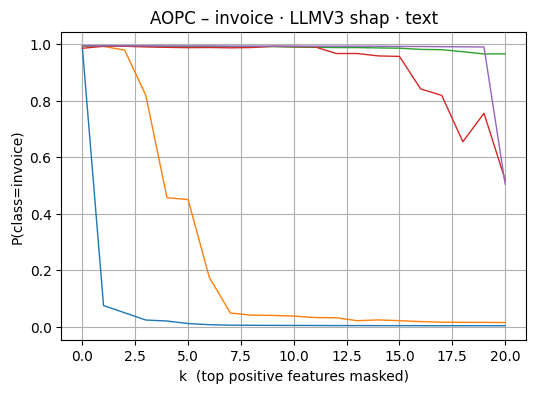

Mean AOPC over 5 samples:  7.0473275


In [136]:
plot_aopc_curves(target_cls="invoice",
                 expl_type="LLMV3 shap",
                 modality="text",
                 K=20,
                 device=device)